# Deep Learning - Melanoma - V2

Plan:
- [X] clean csv and get a proper csv with image file name, label
- [X] get photos into image net format
    - training dataset
    - validation dataset - the folder structure to later be used
- apply basic resnet learner
- start modifying data for unbalanced dataset
    - SMOTE? oversampling? 5 fold cross validation
- apply resnet + training
- add optimizations
- test predictions & results

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.vision import *
import pandas as pd
import numpy as np
import seaborn as sns
import shutil
import os

In [3]:
! pwd

/home/luis/code-projects/dl-melanoma-env/dl-melanoma-env-2


In [4]:
currPathStr = '/home/luis/code-projects/dl-melanoma-env/dl-melanoma-env-2'
currPath = Path('/home/luis/code-projects/dl-melanoma-env/dl-melanoma-env-2')
print(currPath)

/home/luis/code-projects/dl-melanoma-env/dl-melanoma-env-2


## Create clean csv

In [5]:
groundTruthDf = pd.read_csv('ISIC2018_Task3_Training_GroundTruth.csv')
groundTruthDf.head()

,image,MEL,NV,BCC,AKIEC,BKL,DF,VASC
0,ISIC_0024306,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,ISIC_0024307,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,ISIC_0024308,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,ISIC_0024309,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,ISIC_0024310,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [6]:
# given the csv label dataframe, it will return a new dataframe with two columns
# col1 = image: contains the image name
# col2 = classification: contains the abbreviated classification
def createNewLabelDataframe(df):
    imageNames = df['image'].values.tolist()
    for i in range(len(imageNames)):
        imageNames[i] = imageNames[i] + ".jpg"
    classLabels = df.columns[1:].tolist()
    (rowNum, colNum) = df.shape
    labelArray = []
    for i in range(0, rowNum):
        # find the index of the max
        maxIndex = np.argmax(df.iloc[i, 1:].values)
        # get the label of that index
        tempClassLabel  = classLabels[maxIndex]
        # append it to labelArray
        labelArray.append(tempClassLabel)
    labelArray = np.array(labelArray)
#     print(imageNames[0:5])
#     print(labelArray[0:5])
    outputDf = pd.DataFrame({'image_filename':imageNames, 'label':labelArray})
    return outputDf

In [7]:
newLabelsDf = createNewLabelDataframe(groundTruthDf)
newLabelsDf.head()

,image_filename,label
0,ISIC_0024306.jpg,NV
1,ISIC_0024307.jpg,NV
2,ISIC_0024308.jpg,NV
3,ISIC_0024309.jpg,NV
4,ISIC_0024310.jpg,MEL


In [8]:
newLabelsDf.to_csv(currPathStr + "/csv_labels.csv", index=False)

## Create folders for image classes

In [9]:
# clear an existing clean_data dir if it exists
if os.path.exists("clean_data"):
    shutil.rmtree("clean_data")
    print("Removed pre-existing clean_data dir")

Removed pre-existing clean_data dir


In [10]:
classLabels = groundTruthDf.columns[1:].tolist()
classLabels

['MEL', 'NV', 'BCC', 'AKIEC', 'BKL', 'DF', 'VASC']

In [11]:
trainDatasetPath = Path('clean_data/train/skin_cancer')
trainDatasetPathStr = str(trainDatasetPath)
trainDatasetPath.mkdir(parents=True, exist_ok=True)

validDatasetPath = Path('clean_data/valid/skin_cancer')
validDatasetPathStr = str(validDatasetPath)
validDatasetPath.mkdir(parents=True, exist_ok=True)

In [12]:
! ls -la {trainDatasetPath}

total 8
drwxrwxr-x 2 luis luis 4096 Apr  3 23:13 .
drwxrwxr-x 3 luis luis 4096 Apr  3 23:13 ..


In [13]:
! ls -la {validDatasetPath}

total 8
drwxrwxr-x 2 luis luis 4096 Apr  3 23:13 .
drwxrwxr-x 3 luis luis 4096 Apr  3 23:13 ..


In [14]:
for i in classLabels:
    dest1 = trainDatasetPath/i
    dest1.mkdir(parents=True, exist_ok=True)
    dest2 = validDatasetPath/i
    dest2.mkdir(parents=True, exist_ok=True)

In [15]:
! ls -la {trainDatasetPath}

total 36
drwxrwxr-x 9 luis luis 4096 Apr  3 23:13 .
drwxrwxr-x 3 luis luis 4096 Apr  3 23:13 ..
drwxrwxr-x 2 luis luis 4096 Apr  3 23:13 AKIEC
drwxrwxr-x 2 luis luis 4096 Apr  3 23:13 BCC
drwxrwxr-x 2 luis luis 4096 Apr  3 23:13 BKL
drwxrwxr-x 2 luis luis 4096 Apr  3 23:13 DF
drwxrwxr-x 2 luis luis 4096 Apr  3 23:13 MEL
drwxrwxr-x 2 luis luis 4096 Apr  3 23:13 NV
drwxrwxr-x 2 luis luis 4096 Apr  3 23:13 VASC


In [16]:
! ls -la {validDatasetPath}

total 36
drwxrwxr-x 9 luis luis 4096 Apr  3 23:13 .
drwxrwxr-x 3 luis luis 4096 Apr  3 23:13 ..
drwxrwxr-x 2 luis luis 4096 Apr  3 23:13 AKIEC
drwxrwxr-x 2 luis luis 4096 Apr  3 23:13 BCC
drwxrwxr-x 2 luis luis 4096 Apr  3 23:13 BKL
drwxrwxr-x 2 luis luis 4096 Apr  3 23:13 DF
drwxrwxr-x 2 luis luis 4096 Apr  3 23:13 MEL
drwxrwxr-x 2 luis luis 4096 Apr  3 23:13 NV
drwxrwxr-x 2 luis luis 4096 Apr  3 23:13 VASC


In [17]:
# the following function will take a path of images and split them into their proper labels
# into the destination folder
# based on a certain labelled csv

# imagesPath = "./data/train/"
# cleanDataPath = "./clean_data/train/"
# labelledCsvPath = "csv_labels.csv"
def imageNetFormat(imagesPath, cleanDataPath, labelledCsvPath):
    csvDf = pd.read_csv(labelledCsvPath)
    (rowNum, colNum) = csvDf.shape
    for i in range(0, rowNum):
        imageName = csvDf.iloc[i,0]
        imageLabel = csvDf.iloc[i,1]
#         print(imageName)
#         print(imageLabel)
        imagePath = imagesPath + imageName
        newImagePath = cleanDataPath + imageLabel + "/" + imageName
#         print(imagePath)
#         print(newImagePath)
        shutil.copy(imagePath, newImagePath)
    print("Done copying files from " + imagesPath + " into " + cleanDataPath)

## Move the files into imagenet format

In [18]:
# training dataset
imagesPath = "./data/train/"
cleanDataPath = "./clean_data/train/skin_cancer/"
labelledCsvPath = "./csv_labels.csv"
imageNetFormat(imagesPath, cleanDataPath, labelledCsvPath)

Done copying files from ./data/train/ into ./clean_data/train/skin_cancer/


## Dataset Inspection

In [19]:
trainingDf = pd.read_csv("./csv_labels.csv")
trainingDf.head()

,image_filename,label
0,ISIC_0024306.jpg,NV
1,ISIC_0024307.jpg,NV
2,ISIC_0024308.jpg,NV
3,ISIC_0024309.jpg,NV
4,ISIC_0024310.jpg,MEL


In [20]:
trainingDf.shape

(10015, 2)

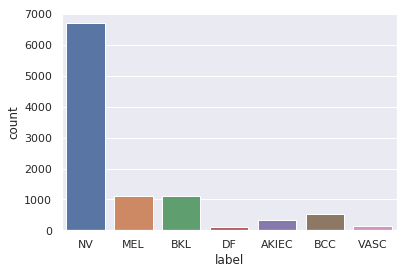

In [21]:
sns.set(style="darkgrid")
ax = sns.countplot(x="label", data=trainingDf)

In [22]:
trainingDf['label'].value_counts()

NV       6705
MEL      1113
BKL      1099
BCC       514
AKIEC     327
VASC      142
DF        115
Name: label, dtype: int64

## Dataset Using New ImageSet Format

In [23]:
np.random.seed(42)
cleanDataPath = "./clean_data"
data = ImageDataBunch.from_folder(cleanDataPath, train="./train/skin_cancer/", valid_pct=0.2,
        ds_tfms=get_transforms(), size=224, num_workers=4).normalize(imagenet_stats)

In [24]:
data.classes

['AKIEC', 'BCC', 'BKL', 'DF', 'MEL', 'NV', 'VASC']

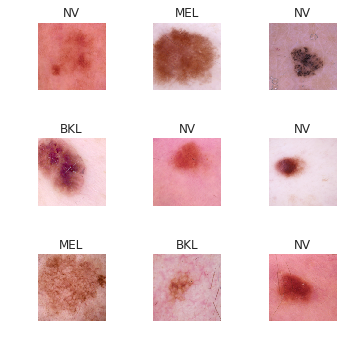

In [25]:
data.show_batch(rows=3, figsize=(5,5), ds_type=DatasetType.Train)

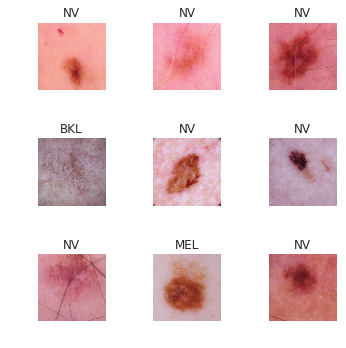

In [26]:
data.show_batch(rows=3, figsize=(5,5), ds_type=DatasetType.Valid)

In [27]:
print("Data classes = ", data.classes)
print("Number of data classes/labels = ", data.c)
print("Number of training dataset", len(data.train_ds))
print("Number of validation dataset", len(data.valid_ds))

Data classes =  ['AKIEC', 'BCC', 'BKL', 'DF', 'MEL', 'NV', 'VASC']
Number of data classes/labels =  7
Number of training dataset 8012
Number of validation dataset 2003


## Naive Model

In [28]:
learn = create_cnn(data, models.resnet34, metrics=error_rate)

In [29]:
learn.fit_one_cycle(5)

epoch,train_loss,valid_loss,error_rate,time
1,1.257975,0.721059,0.244134,01:26
2,0.777819,0.611050,0.220669,01:26
3,0.648647,0.555043,0.197204,01:26
4,0.592313,0.524361,0.193210,01:27
5,0.541177,0.521658,0.188717,01:25


In [30]:
learn.save('stage-1-naive')

In [31]:
learn.unfreeze()

In [32]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


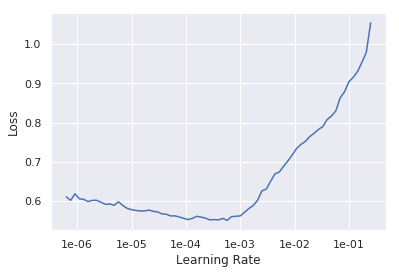

In [33]:
learn.recorder.plot()

In [34]:
learn.fit_one_cycle(2, max_lr=slice(3e-5,3e-4))

epoch,train_loss,valid_loss,error_rate,time
1,0.547741,0.486508,0.177234,01:27
2,0.423458,0.410553,0.148777,01:27


In [35]:
learn.save('stage-1-naive-02')

### Interpretation

In [36]:
learn.load('stage-1-naive-02');

In [37]:
interp = ClassificationInterpretation.from_learner(learn)

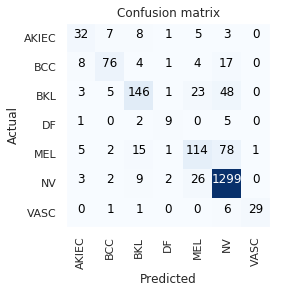

In [38]:
interp.plot_confusion_matrix()